In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
from scipy.io import loadmat, savemat
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

  Cloning https://github.com/ieeg-portal/ieegpy.git to /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-9xb_bodq
  Running command git clone -q https://github.com/ieeg-portal/ieegpy.git /private/var/folders/j3/ps9_bddj0kg0ds3px8t769_00000gn/T/pip-req-build-9xb_bodq
  Resolved https://github.com/ieeg-portal/ieegpy.git to commit 080bfa42a8503380ef164b5e7b116613f75073bb


In [2]:
#Energy
def E(x):
    return np.sum(x ** 2)

#Area
def A(x):
    return np.sum(np.absolute(x))

# number of crossings (zero) - not in
def ZX(x):
    x_demean = x - np.mean(x)
    num_crossings = 0
    for i in range(1, len(x)):
        fromAbove = False
        fromBelow = False
        if x_demean[i - 1] > 0 and x_demean[i] < 0:
            fromAbove = True
        if x_demean[i - 1] < 0 and x_demean[i] > 0:
            fromBelow = True

        if fromAbove or fromBelow:
            num_crossings += 1
    return num_crossings

def bandpower(x, fs, fmin, fmax):
    f, Pxx = sig.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

#concatenates each sequence to form a GDF -- removes the sequences in each runtime
def concat_seqs(I,seqs):
    if seqs[I,0].size != 0:
        X = np.concatenate(np.concatenate(seqs[I,0]))
    else:
        X = []
    return X #recreates the GDF from which the sequence was parsed - I can be used to iterate through the whole code

#take the GDF/runtime --> find the max per ch 
#I refers to the index of the specific sequence runtime we want.
def max_per_runtime(seqs,values,I):
    seq_concat = concat_seqs(I,seqs);
    if len(seq_concat) != 0: #skip past the "no spike detected" sequence runtimes
        ch_uniq = np.unique(seq_concat[:,0])
        all_maxvals = []
        for ch in ch_uniq:
            x = np.where(seq_concat[:,0] == ch)[0] #should give you an array with positions where that unique ch was used.
            all_maxes_per_ch = []
            for x in x: #calls on each array in x --> (example. i == [10 34, 70] for when spike channel == 7)
                val = values[I,0][x] - np.mean(values[I,0][x])
                #INSERT THE FEATURE YOU ARE EXTRACTING
                
                max_val = bandpower(val, fs=len(val)-1, fmin = 25, fmax = 140) #FEATURE APPLICATIONS #AMPLITUDE
                #max_val = np.sum(np.absolute(np.ediff1d(val))) #LINELENGTH
                
                
                all_maxes_per_ch.append(max_val)
            all_maxvals.append([ch, all_maxes_per_ch]) 
    else: #the ones with spikes now
        all_maxvals = []
    return all_maxvals #will return all max values in a runtime

#take the singular max calculator from above and make it run for all sequence run_times
def maxes_for_all(seqs,values):
    all_max_vals = []
    for I in range(len(values)):
        runtime_max_vals = max_per_runtime(seqs,values,I)
        all_max_vals.append(runtime_max_vals)
    return all_max_vals

def create_single_matrix(all_max_vals):
    new_mat = []
    for i in range(len(all_max_vals)):
       for k in range(len(all_max_vals[i])):
           a = all_max_vals[i][k]
           new_mat.append(a)
    return new_mat

def create_uniqch(all_max_vals,chLabels):
    new_mat = create_single_matrix(all_max_vals)
    ch_id = range(len(chLabels[0][0]))
    ch_id = (x+1 for x in ch_id)
    total_maxes = []
    total_maxes_fin = []
    for ch in ch_id:
        ch_maxes = []
        for i in range(len(new_mat)):
            if new_mat[i][0] == ch:
                x = new_mat[i][1]
                ch_maxes.append(x)
        total_maxes.append(ch_maxes)
        
    for chX in total_maxes:
        if len(chX) != 0:
            x = np.concatenate(chX)
            total_maxes_fin.append(x)
        else:
            total_maxes_fin.append([])
        
    return total_maxes_fin

def filter_ch(total_maxes):
    #create a cumulative list that tracks the amount of spikes in each channel
    cumul_list = []
    for maxes in total_maxes:
        cumul_list.append(len(maxes))
    #create a histogram, use the edge of first bin as the cutoff
    _,bins,_ = plt.hist(cumul_list,bins=2*146)
    plt.close()
    filt_maxes = []
    for ch in total_maxes:
        if len(ch) <= bins[1]: #uses the cutoff to threshold what we consider artifacts in a channel
            filt_maxes.append([]);
        else:
            filt_maxes.append(ch)
    return filt_maxes #new total_maxes matrix with no deemed low activity channels

#patient SOZ channels loaded via whichPts-1 indexing and then changed to match ChLabels structure
def prep_chlabels(WhichPts,SOZ_chlabels):
    hup203_soz = (SOZ_chlabels.iloc[WhichPts])
    hup203_soz = [x for x in hup203_soz]
    if isfloat(hup203_soz[0]) == False:
        hup203_soz = hup203_soz[0].replace(" ","")
        hup203_soz = hup203_soz.split(',')
        hup203_soz = [x+'-CAR' for x in hup203_soz]
    else:
        hup203_soz = []
    return hup203_soz

def box_plot(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def box_plot_outliers(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

#full pipeline in 1 function
def load_split(filename):
    pathway = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/Results_v1/split_'
    filetype = '.mat'
    
    split_X = loadmat(pathway+filename+filetype);
    split = split_X
    chLabels = np.transpose(split['chLabels'])
    values = np.transpose(split['values'])
    seqs = np.transpose(split['sequences'])
    leaders = np.transpose(split['leaders'])
    global_coi = np.transpose(split['global_coi'])
    return split, chLabels, values, seqs #global_coi, leaders #you can comment in the global_coi and leaders if need be.

def calc_maxes_and_stats(filename, WhichPts):
    
    split, chLabels, values, seqs = load_split(filename);
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts,SOZ_chlabels)

    if len(hup_soz) != 0:
        SOZ_find = []
        for i in range(len(hup_soz)):
            find = np.where(hup_soz[i] == chLabels[0][0])[0]
            SOZ_find.append(find)

        if len(SOZ_find) != 0:
            SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

            SOZ_find2 = [x+1 for x in SOZ_find]
        else:
            print('NO MATCHES FOR SOZ LABELS ON THE CHLABELS')
            SOZ_find = []
            SOZ_find2 = []
        
    else: 
        hup_soz = hup_soz
        SOZ_find = []
        SOZ_find2 = []
        
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])

    if len(SOZ_find) != 0:
        nonSOZ_all = np.concatenate(nonSOZ_maxes)
        nonSOZ_all = [x for x in nonSOZ_all if np.isnan(x) == False]
        SOZ_all = np.concatenate(SOZ_maxes)
        SOZ_all = [x for x in SOZ_all if np.isnan(x) == False]
        stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)

    else:
        nonSOZ_all = np.concatenate(nonSOZ_maxes)
        SOZ_all = SOZ_maxes   
        print('Stats could not be calculated, no SOZ recorded')
        stats, pval = [], []


    return pval, SOZ_all, nonSOZ_all

def maxes_for_plot(filename, WhichPts):
    split, chLabels, values, seqs = load_split(filename)
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts,SOZ_chlabels)
    if len(hup_soz) != 0:
        SOZ_find = []
        for i in range(len(hup_soz)):
            find = np.where(hup_soz[i] == chLabels[0][0])[0]
            SOZ_find.append(find)

        SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

        SOZ_find2 = [x+1 for x in SOZ_find]
    else: 
        hup_soz = hup_soz
        SOZ_find = []
        SOZ_find2 = []
        
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])
        
    if len(hup_soz) != 0:
        nonSOZ_all = np.concatenate(nonSOZ_maxes)
        nonSOZ_all = [x for x in nonSOZ_all if np.isnan(x) == False]
        SOZ_all = np.concatenate(SOZ_maxes)
        SOZ_all = [x for x in SOZ_all if np.isnan(x) == False]
        stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)

    else:
        nonSOZ_all = np.concatenate(nonSOZ_maxes)
        SOZ_all = SOZ_maxes   
        print('Stats could not be calculated, no SOZ recorded')
        stats, pval = [], []
        
    return filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval, chLabels

def plot_scatter(filename, WhichPts):
    
    filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval,chLabels = maxes_for_plot(filename, WhichPts)
    
    #label_idx = np.arange(1,147)
    label_idx = range(len(chLabels[0][0]))
    label_idx = [x+1 for x in label_idx]
    plt.figure(figsize=(20,10))
    for x, y in zip(label_idx,filt_maxes):
        plt.scatter([x]*len(y), y, color='b',marker=".", s=1)

    for xe, ye in zip(SOZ_find2, SOZ_maxes):
        plt.scatter([xe] * len(ye), ye,color='r',marker=".", s=1)

    plt.title('Max values for each Channel in '+filename)
    SOZ_label = mpatches.Patch(color='r', label='SOZ') #imported matplotlib.patches -> manually creates legend since auto-detection of the legend via plt.legend() didn't work
    nonSOZ_label = mpatches.Patch(color='b', label='non-SOZ')
    plt.legend(handles=[SOZ_label,nonSOZ_label])
    plt.ylabel('Amplitude')
    plt.xlabel('Channel')
    plt.show()
    return 
    
def plot_box_per_pt(filename, WhichPts):
    _, _, _, _, nonSOZ_all, SOZ_all, _, _ = maxes_for_plot(filename, WhichPts)

    plt.figure(figsize=(10,7))
    bp1 = box_plot(nonSOZ_all, [1], 'blue', 'lightblue')
    bp2 = box_plot(SOZ_all, [2], 'red', 'pink')
    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
    plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
    plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for '+filename)
    plt.ylabel('Amplitude')

    x1 = 1
    x2 = 2
    y1 = 1500
    y2 = 1600
    y3 = 1900
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    stat_string = 'statistically significant, p='
    pval_string = stat_string+str(pval)
    plt.text(3/2,1620, s=pval_string, ha='center', va='bottom', color='k')
    plt.ylim([0,1700])
    plt.xlabel('Channel Label')
    plt.show()

    return

def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [3]:
#retrieve filename & whichPts
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_data/filename.pkl", "rb") as f:   #Unpickling
    filename = pickle.load(f)
    
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_data/whichPts.pkl", "rb") as Q:   # Unpickling
    whichPts = pickle.load(Q)

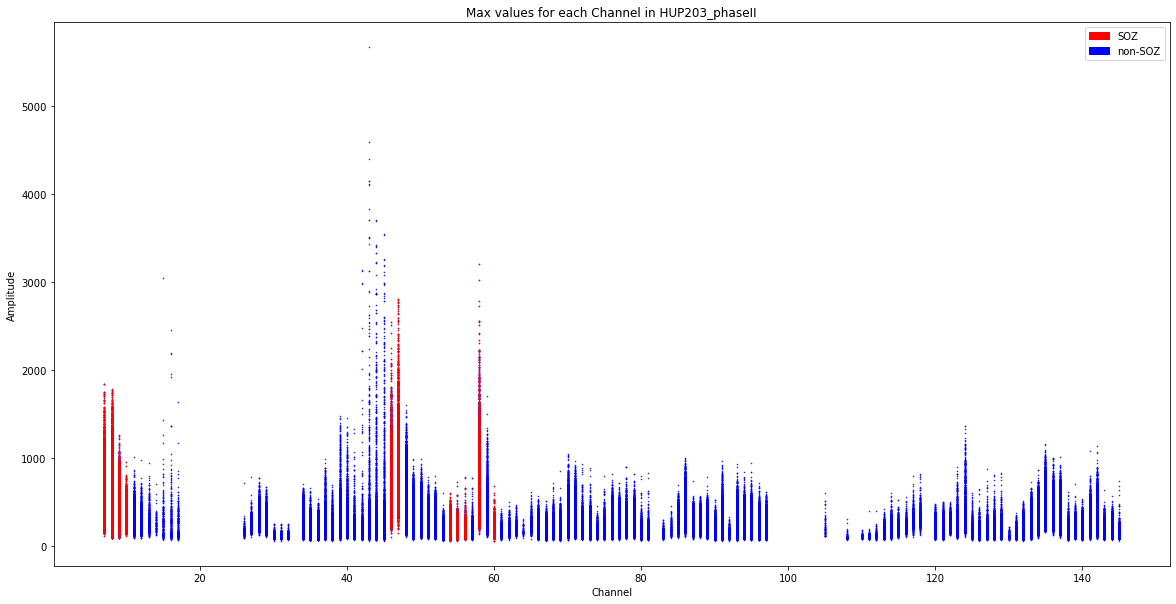

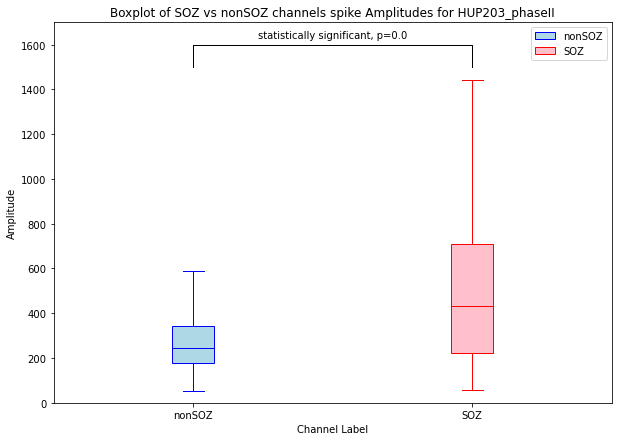

63.03794300000004


In [38]:
#EXAMPLE of CODE - on patient 98 - HUP203_phaseII

#takes about 136 seconds (2.5mins) per patient
import time
start = time.process_time()

#my code
#pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats('HUP203_phaseII',98)
plot_scatter('HUP203_phaseII',98)
plot_box_per_pt('HUP203_phaseII',98)
#mycode

print(time.process_time() - start)

In [69]:
x = np.arange(0,5,1)
print(x)

[0 1 2 3 4]
0


Doing pt -HUP100_phaseII_D01
Stats could not be calculated, no SOZ recorded
Stats could not be calculated, no SOZ recorded


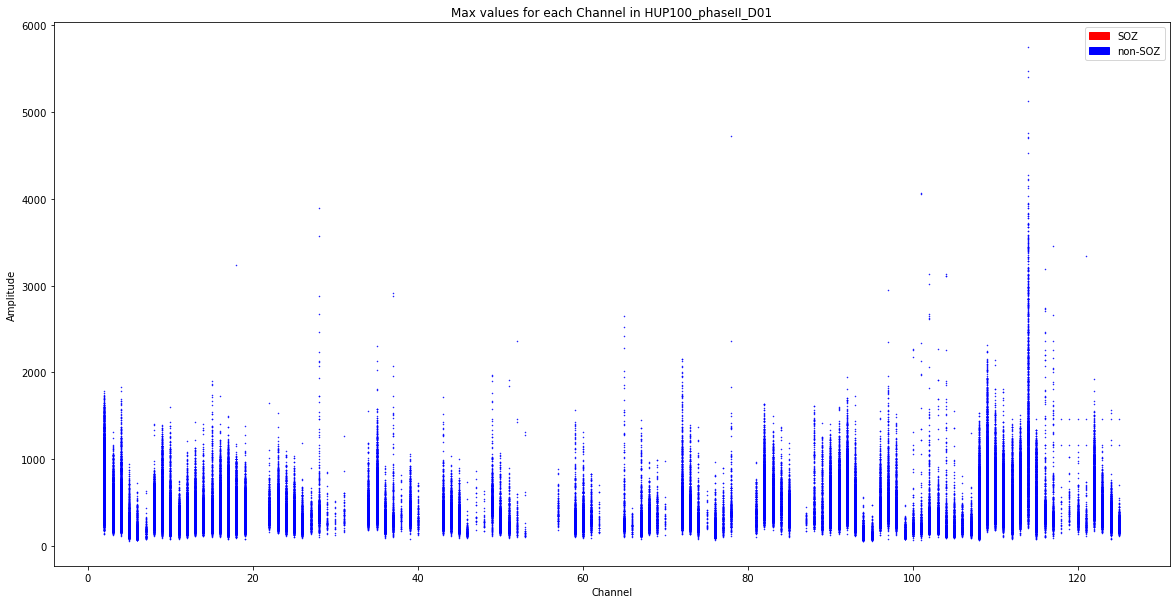

Stats could not be calculated, no SOZ recorded


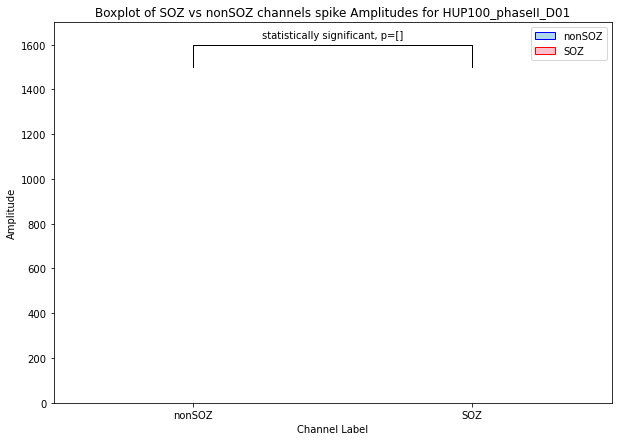

Doing pt -HUP100_phaseII_D02
Stats could not be calculated, no SOZ recorded
Stats could not be calculated, no SOZ recorded


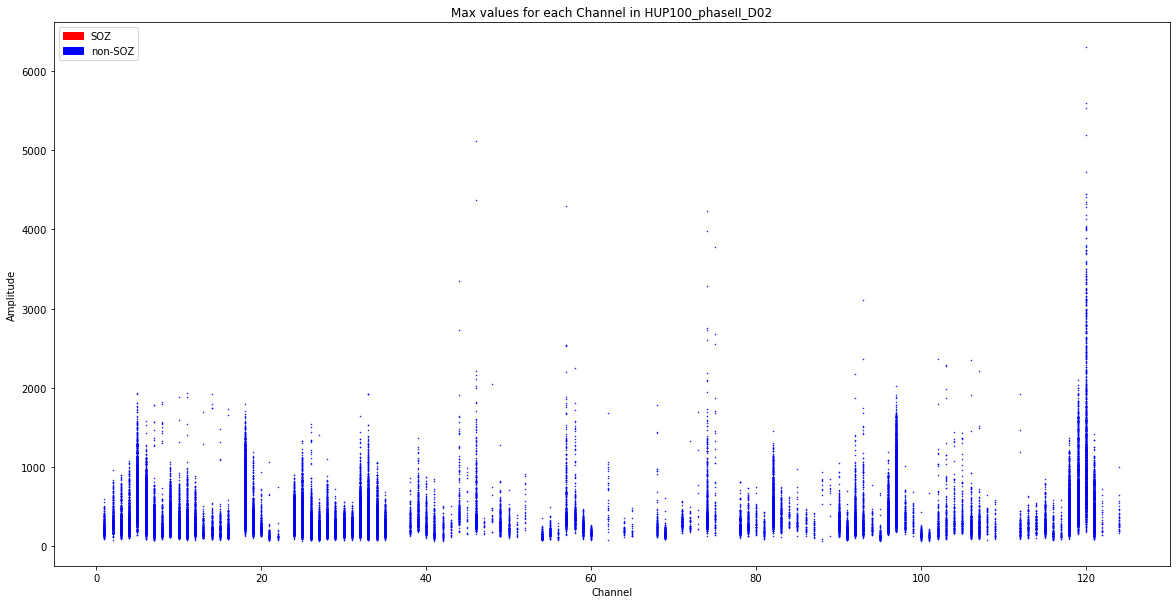

Stats could not be calculated, no SOZ recorded


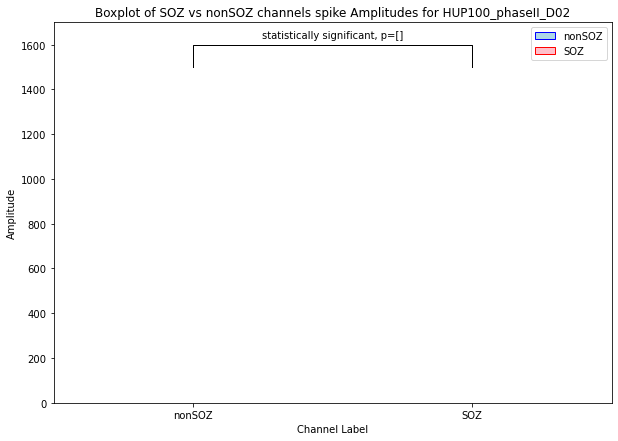

Doing pt -HUP101_phaseII_D01


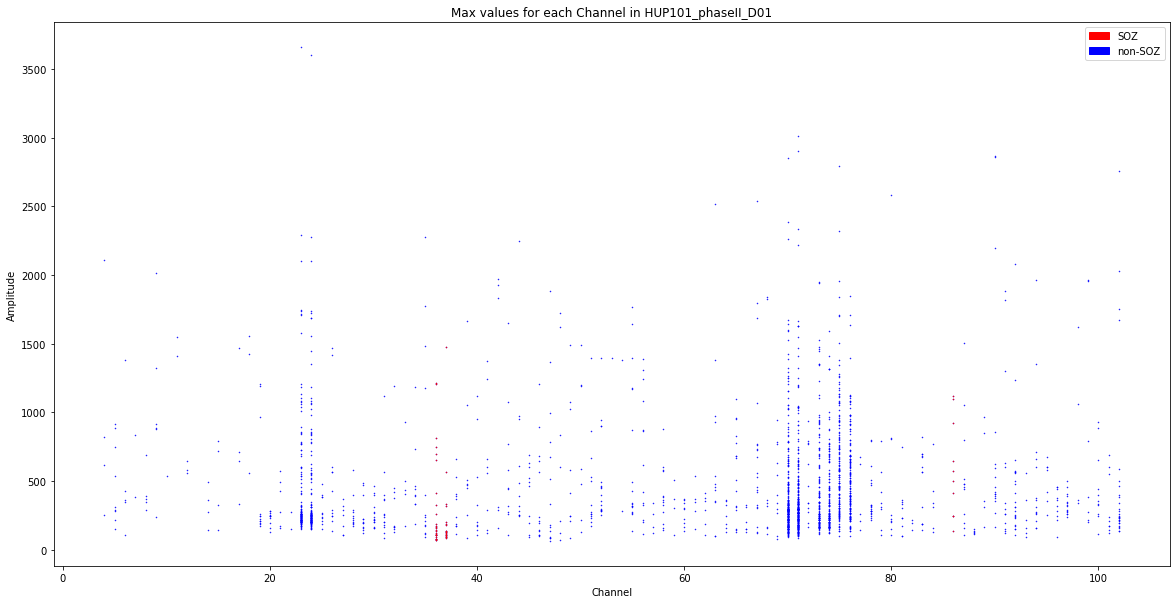

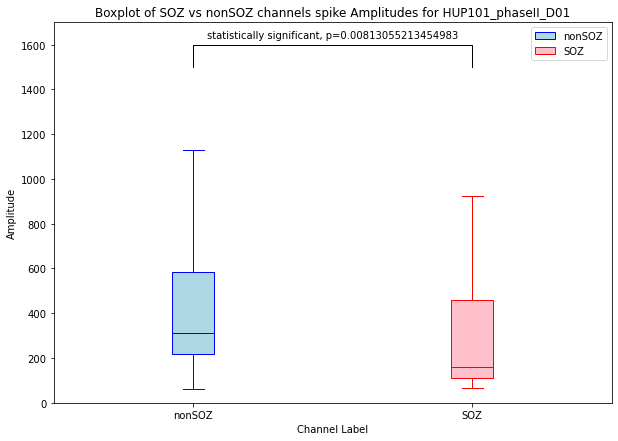

Doing pt -HUP101_phaseII_D02


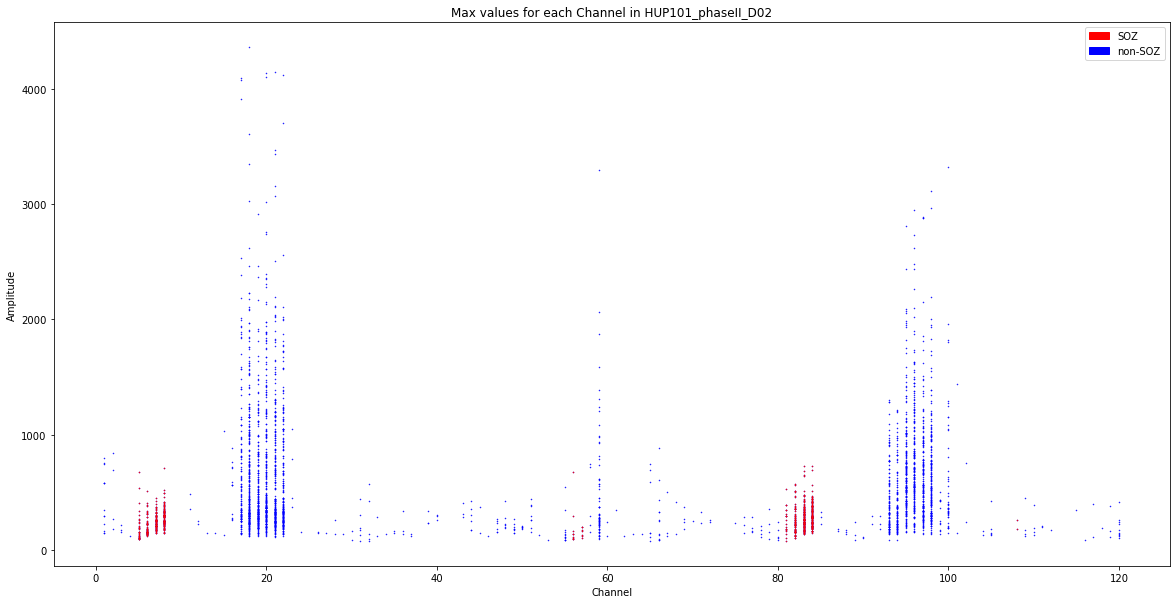

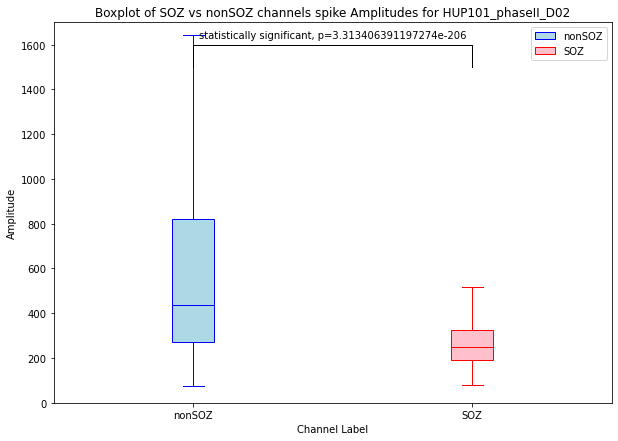

Doing pt -HUP102_phaseII


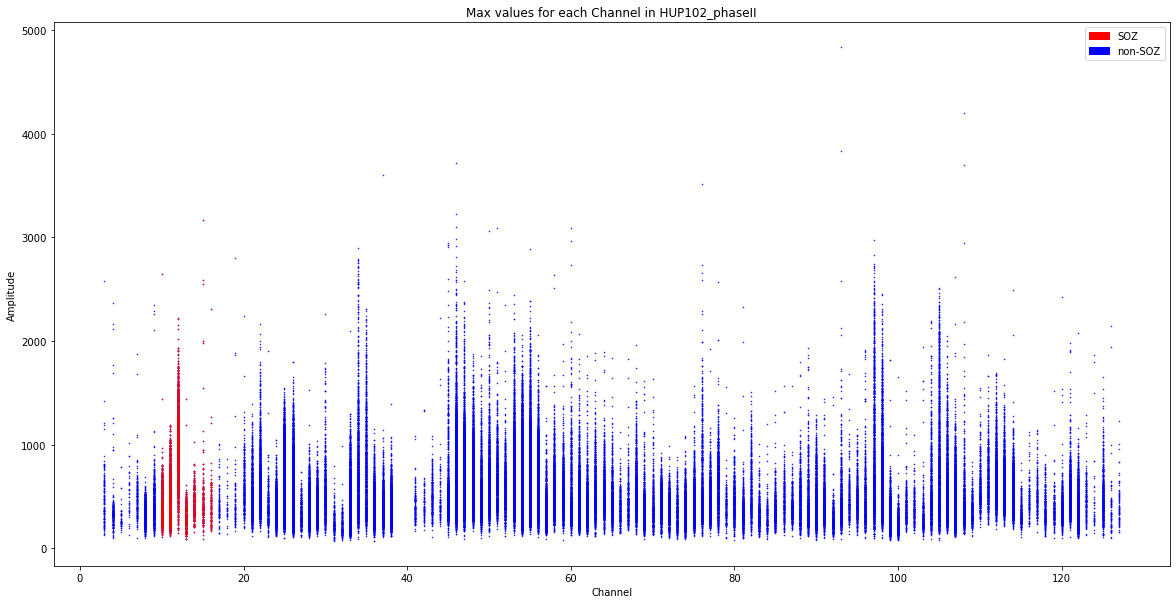

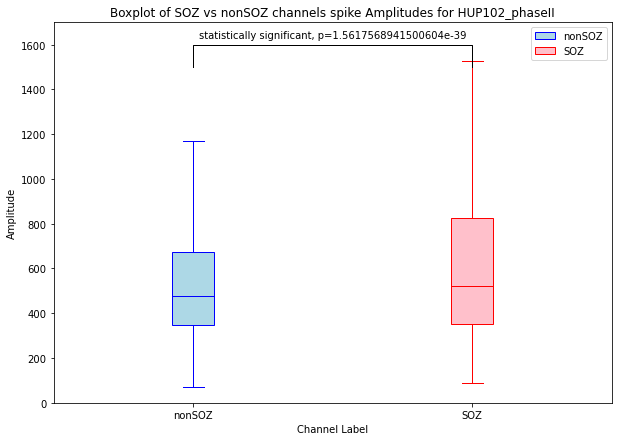

In [114]:
pvals = []
for i in x:
    print('Doing pt -'+filename[i])
    pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats(filename[i], whichPts[i])
    plot_scatter(filename[i], whichPts[i])
    plot_box_per_pt(filename[i], whichPts[i])
    pvals.append(pvals)

TO-DO:
- look at reconciling files
- look at paired t test at the patient level
- look at new way to filter channels, maybe at a spike/min - spike/hour level.
- look at throwing away little channels

DO PRONTO:
- write quick Abstract



In [ ]:
#to look at the spikes/hour rate - i can get total length of the sequences divide by 60 and that should be in the hour dimension
#then from there i can see if the total spikes/hour is enough.

#to reconcile the files i can do it before or afterwards. As long as the SOZ channels don't change i can just filter them and concatenate the features.
# HOWEVER if this would have to be done afterwards everytime, instead of a set piece to work off of.

#paired t test work on that with the average of the SOZ/nonSOZ channels ampitudes - for now we just plot these intermediate plots for context. 

In [4]:
#MEAN MAXES

X = range(len(filename))
pvals1 = []
SOZ_all_mean1 = []
nonSOZ_all_mean1 = []
SOZ_all_X1 = []
nonSOZ_all_X1 =[]
from os.path import exists

for file in X:
    pathway = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/Results_v1/split_'
    filetype = '.mat'
    
    if exists(pathway+filename[file]+filetype) == True:
        print('Doing pt -'+filename[file])
        split_X = loadmat(pathway+filename[file]+filetype);
        pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats(filename[file], whichPts[file])
        SOZ_all_mean1.append(np.mean(SOZ_all))
        SOZ_all_X1.append(SOZ_all)
        nonSOZ_all_mean1.append(np.mean(nonSOZ_all))
        nonSOZ_all_X1.append(nonSOZ_all)
        pvals1.append(pval)

Doing pt -HUP100_phaseII_D01
Stats could not be calculated, no SOZ recorded
Doing pt -HUP100_phaseII_D02


/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Stats could not be calculated, no SOZ recorded
Doing pt -HUP101_phaseII_D01
Doing pt -HUP101_phaseII_D02
Doing pt -HUP102_phaseII
Doing pt -HUP105_phaseII
Doing pt -HUP106_phaseII
Doing pt -HUP107_phaseII
Doing pt -HUP108_phaseII
Doing pt -HUP110_phaseII_D01
Doing pt -HUP110_phaseII_D02
Doing pt -HUP111_phaseII_D01
Doing pt -HUP111_phaseII_D02
Doing pt -HUP112_phaseII
Stats could not be calculated, no SOZ recorded
Doing pt -HUP113_phaseII_D01
Doing pt -HUP113_phaseII_D02
Doing pt -HUP114_phaseII
Doing pt -HUP115_phaseII
Doing pt -HUP116_phaseII
Doing pt -HUP117_phaseII_D01
Doing pt -HUP117_phaseII_D02
Doing pt -HUP117_phaseII_D03
Doing pt -HUP118_phaseII_D01
Doing pt -HUP118_phaseII_D02
Doing pt -HUP120_phaseII
Doing pt -HUP121_phaseII
Doing pt -HUP122_phaseII_D01
Doing pt -HUP122_phaseII_D02
Doing pt -HUP123_phaseII_D01
Doing pt -HUP123_phaseII_D02
Doing pt -HUP124_phaseII_D01
Doing pt -HUP124_phaseII_D02
Doing pt -HUP124_phaseII_D03
Doing pt -HUP126_phaseII_D01
Doing pt -HUP126_phase

In [9]:
SOZ_all_mean_21 = []
nonSOZ_all_mean_21 = []
SOZ_all_X21 = []
nonSOZ_all_X21 =[]

for i in range(len(SOZ_all_mean1)):
    if np.isnan(SOZ_all_mean1[i]) == False:
        SOZ_all_mean_21.append(SOZ_all_mean1[i])
        nonSOZ_all_mean_21.append(nonSOZ_all_mean1[i])
        SOZ_all_X21.append(SOZ_all_X1[i])
        nonSOZ_all_X21.append(nonSOZ_all_X1[i])

In [10]:
SOZ_all_X21 = [[SOZ_all_X1[2]+SOZ_all_X1[3]], SOZ_all_X1[4],SOZ_all_X1[5],SOZ_all_X1[6],SOZ_all_X1[7],SOZ_all_X1[8],[SOZ_all_X1[9]+SOZ_all_X1[10]], [SOZ_all_X1[11]+SOZ_all_X1[12]],[SOZ_all_X1[14]+SOZ_all_X1[15]],SOZ_all_X1[16],SOZ_all_X1[17],SOZ_all_X1[18], [SOZ_all_X1[19]+SOZ_all_X1[20]+SOZ_all_X1[21]], [SOZ_all_X1[22]+SOZ_all_X1[23]], SOZ_all_X1[24],SOZ_all_X1[25], [SOZ_all_X1[26]+SOZ_all_X1[27]], [SOZ_all_X1[28]+SOZ_all_X1[29]], [SOZ_all_X1[20]+SOZ_all_X1[31]+SOZ_all_X1[32]], [SOZ_all_X1[33]+SOZ_all_X1[34]], SOZ_all_X1[35],SOZ_all_X1[37],SOZ_all_X1[38],SOZ_all_X1[39],SOZ_all_X1[40],[SOZ_all_X1[41]+SOZ_all_X1[42]+SOZ_all_X1[43]],SOZ_all_X1[44],SOZ_all_X1[45],SOZ_all_X1[46],SOZ_all_X1[47],SOZ_all_X1[48],SOZ_all_X1[49],SOZ_all_X1[50],SOZ_all_X1[51]  ]
nonSOZ_all_X21 = [[nonSOZ_all_X1[2]+nonSOZ_all_X1[3]], nonSOZ_all_X1[4],nonSOZ_all_X1[5],nonSOZ_all_X1[6],nonSOZ_all_X1[7],nonSOZ_all_X1[8],[nonSOZ_all_X1[9]+nonSOZ_all_X1[10]], [nonSOZ_all_X1[11]+nonSOZ_all_X1[12]],[nonSOZ_all_X1[14]+nonSOZ_all_X1[15]],nonSOZ_all_X1[16],nonSOZ_all_X1[17],nonSOZ_all_X1[18], [nonSOZ_all_X1[19]+nonSOZ_all_X1[20]+nonSOZ_all_X1[21]], [nonSOZ_all_X1[22]+nonSOZ_all_X1[23]], nonSOZ_all_X1[24],nonSOZ_all_X1[25], [nonSOZ_all_X1[26]+nonSOZ_all_X1[27]], [nonSOZ_all_X1[28]+nonSOZ_all_X1[29]], [nonSOZ_all_X1[20]+nonSOZ_all_X1[31]+nonSOZ_all_X1[32]], [nonSOZ_all_X1[33]+nonSOZ_all_X1[34]], nonSOZ_all_X1[35],nonSOZ_all_X1[37],nonSOZ_all_X1[38],nonSOZ_all_X1[39],nonSOZ_all_X1[40],[nonSOZ_all_X1[41]+nonSOZ_all_X1[42]+nonSOZ_all_X1[43]],nonSOZ_all_X1[44],nonSOZ_all_X1[45],nonSOZ_all_X1[46],nonSOZ_all_X1[47],nonSOZ_all_X1[48],nonSOZ_all_X1[49],nonSOZ_all_X1[50],nonSOZ_all_X1[51]  ]
SOZ_all_X2_mean1 = [np.mean(x) for x in SOZ_all_X21]
nonSOZ_all_X2_mean1 = [np.mean(x) for x in nonSOZ_all_X21]

In [11]:
ttest_rel(SOZ_all_X2_mean1,nonSOZ_all_X2_mean1)

Ttest_relResult(statistic=2.2000428468517814, pvalue=0.034913688516002434)

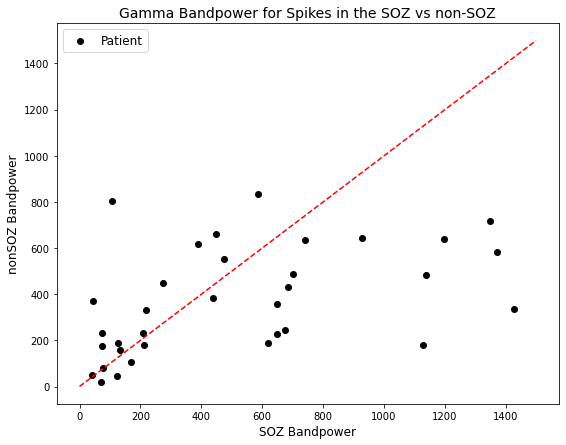

In [12]:
plt.figure(figsize=[9,7])
plt.title('Gamma Bandpower for Spikes in the SOZ vs non-SOZ',fontsize=14)
plt.scatter(SOZ_all_X2_mean1,nonSOZ_all_X2_mean1,color='k',marker='o',label='Patient')
plt.xlabel('SOZ Bandpower',fontsize=12)
plt.ylabel('nonSOZ Bandpower',fontsize=12)
y = np.arange(0,1500,1)
x = np.arange(0,1500,1)
plt.plot(x,y,linestyle='dashed',color='r')
#plt.ylim([100,800])
#plt.xlim([100,1200])
plt.legend(fontsize=12)
plt.savefig('fig_2_pts_BP_GAMMA.jpeg',dpi=100)
plt.show()

---

In [164]:
X = range(len(filename))
pvals = []
SOZ_all_mean = []
nonSOZ_all_mean = []
SOZ_all_X = []
nonSOZ_all_X =[]
from os.path import exists

for file in X:
    pathway = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/Results_v1/split_'
    filetype = '.mat'
    
    if exists(pathway+filename[file]+filetype) == True:
        print('Doing pt -'+filename[file])
        split_X = loadmat(pathway+filename[file]+filetype);
        pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats(filename[file], whichPts[file])
        SOZ_all_mean.append(np.mean(SOZ_all))
        SOZ_all_X.append(SOZ_all)
        nonSOZ_all_mean.append(np.mean(nonSOZ_all))
        nonSOZ_all_X.append(nonSOZ_all)
        pvals.append(pval)

Doing pt -HUP100_phaseII_D01
Stats could not be calculated, no SOZ recorded
Doing pt -HUP100_phaseII_D02


/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Stats could not be calculated, no SOZ recorded
Doing pt -HUP101_phaseII_D01
Doing pt -HUP101_phaseII_D02
Doing pt -HUP102_phaseII
Doing pt -HUP105_phaseII
Doing pt -HUP106_phaseII
Doing pt -HUP107_phaseII
Doing pt -HUP108_phaseII
Doing pt -HUP110_phaseII_D01
Doing pt -HUP110_phaseII_D02
Doing pt -HUP111_phaseII_D01
Doing pt -HUP111_phaseII_D02
Doing pt -HUP112_phaseII
Stats could not be calculated, no SOZ recorded
Doing pt -HUP113_phaseII_D01
Doing pt -HUP113_phaseII_D02
Doing pt -HUP114_phaseII
Doing pt -HUP115_phaseII
Doing pt -HUP116_phaseII
Doing pt -HUP117_phaseII_D01
Doing pt -HUP117_phaseII_D02
Doing pt -HUP117_phaseII_D03
Doing pt -HUP118_phaseII_D01
Doing pt -HUP118_phaseII_D02
Doing pt -HUP120_phaseII
Doing pt -HUP121_phaseII
Doing pt -HUP122_phaseII_D01
Doing pt -HUP122_phaseII_D02
Doing pt -HUP123_phaseII_D01
Doing pt -HUP123_phaseII_D02
Doing pt -HUP124_phaseII_D01
Doing pt -HUP124_phaseII_D02
Doing pt -HUP124_phaseII_D03
Doing pt -HUP126_phaseII_D01
Doing pt -HUP126_phase

In [165]:
SOZ_all_mean_2 = []
nonSOZ_all_mean_2 = []
SOZ_all_X2 = []
nonSOZ_all_X2 =[]

for i in range(len(SOZ_all_mean)):
    if np.isnan(SOZ_all_mean[i]) == False:
        SOZ_all_mean_2.append(SOZ_all_mean[i])
        nonSOZ_all_mean_2.append(nonSOZ_all_mean[i])
        SOZ_all_mean_X2.append(SOZ_all_X[i])
        nonSOZ_all_mean_X2.append(nonSOZ_all_X[i])

In [166]:
SOZ_all_X2 = [[SOZ_all_X[2]+SOZ_all_X[3]], SOZ_all_X[4],SOZ_all_X[5],SOZ_all_X[6],SOZ_all_X[7],SOZ_all_X[8],[SOZ_all_X[9]+SOZ_all_X[10]], [SOZ_all_X[11]+SOZ_all_X[12]],[SOZ_all_X[14]+SOZ_all_X[15]],SOZ_all_X[16],SOZ_all_X[17],SOZ_all_X[18], [SOZ_all_X[19]+SOZ_all_X[20]+SOZ_all_X[21]], [SOZ_all_X[22]+SOZ_all_X[23]], SOZ_all_X[24],SOZ_all_X[25], [SOZ_all_X[26]+SOZ_all_X[27]], [SOZ_all_X[28]+SOZ_all_X[29]], [SOZ_all_X[20]+SOZ_all_X[31]+SOZ_all_X[32]], [SOZ_all_X[33]+SOZ_all_X[34]], SOZ_all_X[35],SOZ_all_X[37],SOZ_all_X[38],SOZ_all_X[39],SOZ_all_X[40],[SOZ_all_X[41]+SOZ_all_X[42]+SOZ_all_X[43]],SOZ_all_X[44],SOZ_all_X[45],SOZ_all_X[46],SOZ_all_X[47],SOZ_all_X[48],SOZ_all_X[49],SOZ_all_X[50],SOZ_all_X[51]  ]
nonSOZ_all_X2 = [[nonSOZ_all_X[2]+nonSOZ_all_X[3]], nonSOZ_all_X[4],nonSOZ_all_X[5],nonSOZ_all_X[6],nonSOZ_all_X[7],nonSOZ_all_X[8],[nonSOZ_all_X[9]+nonSOZ_all_X[10]], [nonSOZ_all_X[11]+nonSOZ_all_X[12]],[nonSOZ_all_X[14]+nonSOZ_all_X[15]],nonSOZ_all_X[16],nonSOZ_all_X[17],nonSOZ_all_X[18], [nonSOZ_all_X[19]+nonSOZ_all_X[20]+nonSOZ_all_X[21]], [nonSOZ_all_X[22]+nonSOZ_all_X[23]], nonSOZ_all_X[24],nonSOZ_all_X[25], [nonSOZ_all_X[26]+nonSOZ_all_X[27]], [nonSOZ_all_X[28]+nonSOZ_all_X[29]], [nonSOZ_all_X[20]+nonSOZ_all_X[31]+nonSOZ_all_X[32]], [nonSOZ_all_X[33]+nonSOZ_all_X[34]], nonSOZ_all_X[35],nonSOZ_all_X[37],nonSOZ_all_X[38],nonSOZ_all_X[39],nonSOZ_all_X[40],[nonSOZ_all_X[41]+nonSOZ_all_X[42]+nonSOZ_all_X[43]],nonSOZ_all_X[44],nonSOZ_all_X[45],nonSOZ_all_X[46],nonSOZ_all_X[47],nonSOZ_all_X[48],nonSOZ_all_X[49],nonSOZ_all_X[50],nonSOZ_all_X[51]  ]
SOZ_all_X2_mean = [np.mean(x) for x in SOZ_all_X2]
nonSOZ_all_X2_mean = [np.mean(x) for x in nonSOZ_all_X2]

In [167]:
ttest_rel(SOZ_all_X2_mean,nonSOZ_all_X2_mean)

Ttest_relResult(statistic=3.040735129163042, pvalue=0.0045980632342360345)

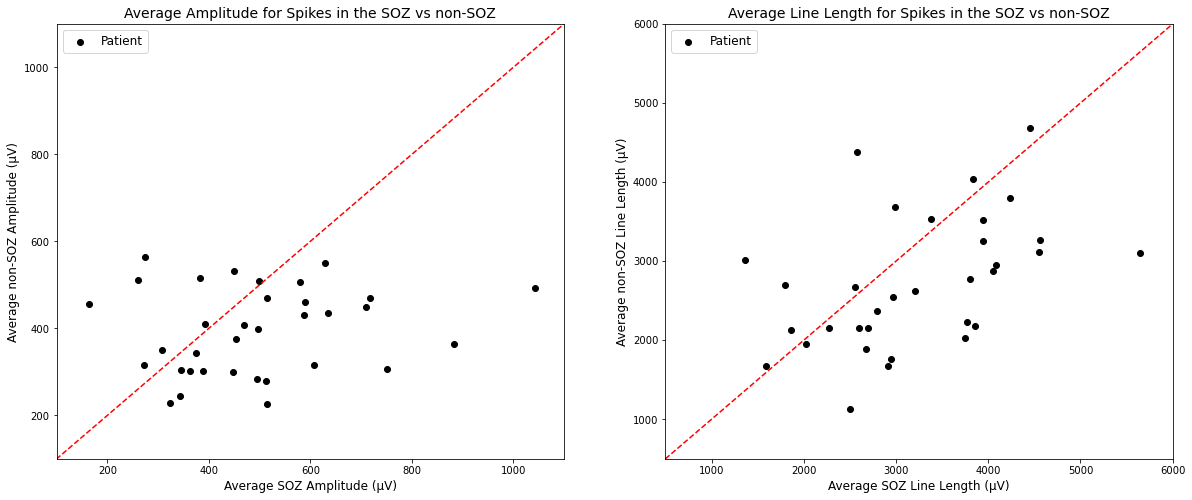

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))

axs[0].set_title('Average Amplitude for Spikes in the SOZ vs non-SOZ',fontsize=14)
axs[0].scatter(SOZ_all_X2_mean1,nonSOZ_all_X2_mean1,color='k',marker='o',label='Patient')
axs[0].set_xlabel('Average SOZ Amplitude (\u03BCV)',fontsize=12)
axs[0].set_ylabel('Average non-SOZ Amplitude (\u03BCV)',fontsize=12)
y = np.arange(0,1500,1)
x = np.arange(0,1500,1)
axs[0].plot(x,y,linestyle='dashed',color='r')
axs[0].set_ylim([100,1100])
axs[0].set_xlim([100,1100])
axs[0].legend(fontsize=12)

axs[1].set_title('Average Line Length for Spikes in the SOZ vs non-SOZ',fontsize=14)
axs[1].scatter(SOZ_all_X2_mean,nonSOZ_all_X2_mean,color='k',marker='o',label='Patient')
axs[1].set_xlabel('Average SOZ Line Length (\u03BCV)',fontsize=12)
axs[1].set_ylabel('Average non-SOZ Line Length (\u03BCV)',fontsize=12)
y = np.arange(0,7000,1)
x = np.arange(0,7000,1)
axs[1].set_ylim([500,6000])
axs[1].set_xlim([500,6000])
axs[1].plot(x,y,linestyle='dashed',color='r')
axs[1].legend(fontsize=12)
fig.savefig('fig_2_pts.jpeg',dpi=100)
plt.show()

IDEAS:

classify spikes into slow waves spikes - use this counter as a feature
if that shows fruitful use features from slow waves to id more 

some bandpower features
perhaps a zero crossings? almost like a frequency thing going on.
look at power? area? density? Area under the curve

look at sequence leaders?